In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt


from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# functions definition

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
    le_list = []
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
        le_list.append(le)
    return (df, le_list)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_list):
    for i, column in enumerate(df.columns):
        le = le_list[i]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df


# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - DNN')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data

# split the training and testing sets manually, make sure that positive data is in the testing set
def train_test_split_m(X, y, positive_list, test_size=0.33):

    sample_len = int(len(X) * 0.33 - len(positive_list))
    
    X_test = X.iloc[positive_list]
    X = X.drop(positive_list)
    
    X_random = X.sample(sample_len)
    X = X.drop(X_random.index)
    X_test = pd.concat([X_test, X_random], axis=0, ignore_index=True)
    y_test = list([1 for i in range(len(positive_list))] + [0 for i in range(sample_len)])

    X_train = X
    y_train = [0 for i in range(len(X_train))]
    
    return (X_train, X_test, y_train, y_test)

## DNN Model

The neural networks that were investigated by this research 
had hidden layer counts between one and five. Neuron counts 
for the first hidden layer were three times the number of input 
neurons needed for the feature vector. The neuron counts for 
subsequent hidden layers were half of the preceding layer. 
Using this methodology a 50 input neural network would 
contain hidden counts of [150, 75, 37, 18] for a four hidden 
layer network.

All hidden layers made use of the rectified linear unit 
(ReLU) transfer function. The adaptive moment 
estimation (Adam) was used to train the neural network. 
Weight initialization was accomplished using the Xavier 
algorithm. The feature vector was optimized using a 
feature ranking algorithm that was developed specifically for 
TensorFlow. 

Refernces: *Deep Learning for Prioritizing and Responding to Intrusion Detection Alerts* https://ieeexplore.ieee.org/abstract/document/8170757

*Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift* http://proceedings.mlr.press/v37/ioffe15.html


In [44]:
def DNN_model(input_len, layer=4):
    
    # Define the input shape
    input_shape = (input_len,)
    
    # Define the number of neurons in each hidden layer
    if layer == 1:
        hidden_counts = [input_len*3]
    elif layer == 2:
        hidden_counts = [input_len*3, int(input_len*3/2)]
    elif layer == 3:
        hidden_counts = [input_len*3, int(input_len*3/2), int(input_len*3/2/2)]
    elif layer == 4:
        hidden_counts = [input_len*3, int(input_len*3/2), int(input_len*3/2)/2, int(input_len*3/2/2/2)]
    else:
        hidden_counts = [input_len*3, int(input_len*3/2), int(input_len*3/2/2), int(input_len*3/2/2/2), int(input_len*3/2/2/2/2)]

    # Define the number of output neurons
    num_classes = 1

    # Define the activation function for the hidden layers
    activation_fn = 'relu'

    # Define the weight initializer
    initializer = GlorotUniform(seed=42)

    # Define the optimizer
    optimizer = Adam()

    # Define the model architecture
    model = tf.keras.Sequential()

    # Add the input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Add the hidden layers
    for i, count in enumerate(hidden_counts):
        model.add(layers.Dense(count, activation=activation_fn, kernel_initializer=initializer, name=f'hidden_{i+1}'))

    # Add the output layer
    # model.add(layers.Dense(num_classes, activation='softmax', kernel_initializer=initializer, name='output'))
    model.add(layers.Dense(num_classes, activation='sigmoid', kernel_initializer=initializer, name='output'))


    # Compile the model
    # model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])#, 'AUC'
    
    return model
    

def DNN_classifier(df, y, y_index, gen_data, hidden_layers=3, manually=False):
    
    # preprocess
    X = preprocess(df)
    X, le_dict = labelEncoder_get(X)
    if manually:
        X_train, X_test, y_train, y_test = train_test_split_m(X, y, y_index)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
    
    
    # add generated data to the original training set
    X_gen = preprocess(gen_data)
    X_gen = labelEncoder_trans(X_gen, le_dict)
    X_train_new = pd.concat([X_train, X_gen], axis=0)
    # generated data are all positive
    for i in range(len(gen_data)):
        y_train.append(1)
    
    # z-score scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train_new)
    
    ## DNN Model
    model = DNN_model(len(X.columns))
    y_train = np.array(y_train) #
    hist = model.fit(X_scaled, y_train, verbose=2, epochs=50)
    plt.plot(hist.history['accuracy'])
    plt.show()
    
    # prediction
    y_predict = model.predict(X_test)
    y_predict_class = np.where(y_predict >= 0.5, 1, 0) # use 0.5 as threshold
    draw_confusionMatrix(y_test, y_predict_class)
    
    return 0

In [83]:
# AD Object
# read the original dataset
datasetJSONPath = os.getcwd() + "\\datasets\\empire_dcsync_dcerpc_drsuapi_DsGetNCChanges_2020-09-21185829.json"
df1 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "AccessMask", "Properties", "SubjectUserName", "LogonType", "SubjectLogonId", "TargetLogonId"]
df1 = df1[features]

Y1 = labelList(df1.shape[0], [5125, 5126, 5127, 5114])

# read the generated data
gen_data1 = json.read_json(path_or_buf=os.getcwd()+ r'\generated_datasets\empire_dcsync_dcerpc_drsuapi_DsGetNCChanges_new.json')

print(df1.shape, gen_data1.shape)

(8465, 8) (5600, 8)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
353/353 - 1s - loss: 0.3996 - accuracy: 0.9622 - 571ms/epoch - 2ms/step
Epoch 2/50
353/353 - 0s - loss: 0.2326 - accuracy: 0.9989 - 245ms/epoch - 695us/step
Epoch 3/50
353/353 - 0s - loss: 0.1793 - accuracy: 0.9992 - 238ms/epoch - 673us/step
Epoch 4/50
353/353 - 0s - loss: 0.1410 - accuracy: 0.9996 - 246ms/epoch - 698us/step
Epoch 5/50
353/353 - 0s - loss: 0.1126 -

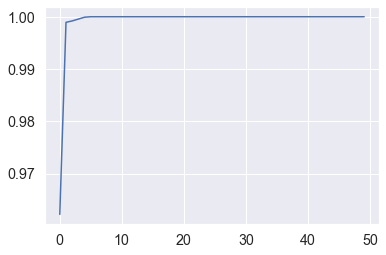

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


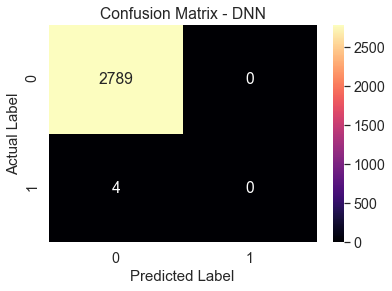

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2789
           1       0.00      0.00      0.00         4

    accuracy                           1.00      2793
   macro avg       0.50      0.50      0.50      2793
weighted avg       1.00      1.00      1.00      2793



C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0

In [84]:
DNN_classifier(df1, Y1, [5125, 5126, 5127, 5114], gen_data1, hidden_layers=5, manually=True)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
73/73 - 0s - loss: 0.6330 - accuracy: 0.7763 - 414ms/epoch - 6ms/step
Epoch 2/50
73/73 - 0s - loss: 0.5304 - accuracy: 0.8946 - 62ms/epoch - 851us/step
Epoch 3/50
73/73 - 0s - loss: 0.4744 - accuracy: 0.9216 - 57ms/epoch - 782us/step
Epoch 4/50
73/73 - 0s - loss: 0.4422 - accuracy: 0.9276 - 68ms/epoch - 931us/step
Epoch 5/50
73/73 - 0s - loss: 0.4202 - accuracy: 0.

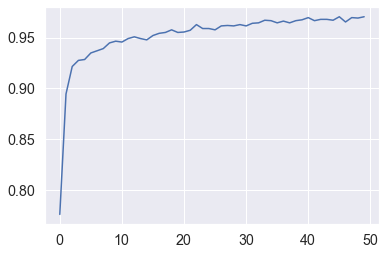

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


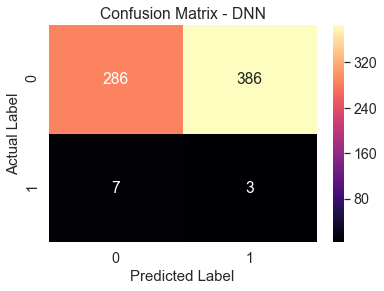

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.98      0.43      0.59       672
           1       0.01      0.30      0.02        10

    accuracy                           0.42       682
   macro avg       0.49      0.36      0.30       682
weighted avg       0.96      0.42      0.58       682



0

In [85]:
# Local PS
datasetJSONPath = os.getcwd() + "\\datasets\\empire_launcher_vbs_2020-09-04160940.json"
df2 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "NewProcessName", "ParentProcessName", "Image", "ImageLoaded", "Description", "PipeName"] # "ParentImage", 
df2 = df2[features]

Y2 = labelList(df2.shape[0], [876, 1251, 1325, 1370, 1372, 327, 258, 1100, 1106, 913])

gen_data2 = json.read_json(os.getcwd() + "\\generated_datasets\\empire_launcher_vbs_new.json")

DNN_classifier(df2, Y2, [876, 1251, 1325, 1370, 1372, 327, 258, 1100, 1106, 913], gen_data2, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
91/91 - 0s - loss: 0.6720 - accuracy: 0.6442 - 401ms/epoch - 4ms/step
Epoch 2/50
91/91 - 0s - loss: 0.5342 - accuracy: 0.8633 - 71ms/epoch - 776us/step
Epoch 3/50
91/91 - 0s - loss: 0.4020 - accuracy: 0.8948 - 66ms/epoch - 725us/step
Epoch 4/50
91/91 - 0s - loss: 0.2278 - accuracy: 0.9457 - 72ms/epoch - 786us/step
Epoch 5/50
91/91 - 0s - loss: 0.1443 - accuracy: 0.

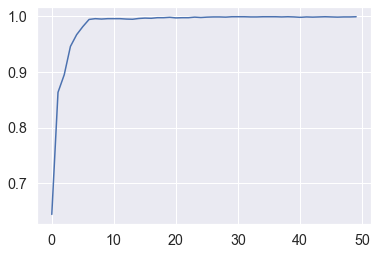

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


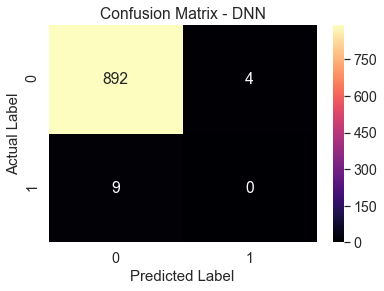

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       896
           1       0.00      0.00      0.00         9

    accuracy                           0.99       905
   macro avg       0.50      0.50      0.50       905
weighted avg       0.98      0.99      0.98       905



0

In [86]:
# PS Remote
datasetJSONPath = os.getcwd() + "\\datasets\\empire_psremoting_stager_2020-09-20170827.json"
df3 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "Message", "DestPort", "LayerRTID", "ParentProcessName", "NewProcessName", "ParentImage", "Image", "DestinationPort", "User"]
df3 = df3[features]
Y3 = labelList(df3.shape[0], [678, 478, 745, 856, 535, 867, 689, 1415, 1418])

gen_data3 = json.read_json(os.getcwd() + "\\generated_datasets\\empire_psremoting_stager_new1.json")

DNN_classifier(df3, Y3, [678, 478, 745, 856, 535, 867, 689, 1415, 1418], gen_data3, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
116/116 - 0s - loss: 0.6035 - accuracy: 0.8120 - 426ms/epoch - 4ms/step
Epoch 2/50
116/116 - 0s - loss: 0.3996 - accuracy: 0.9520 - 83ms/epoch - 716us/step
Epoch 3/50
116/116 - 0s - loss: 0.3502 - accuracy: 0.9601 - 78ms/epoch - 674us/step
Epoch 4/50
116/116 - 0s - loss: 0.3212 - accuracy: 0.9631 - 82ms/epoch - 709us/step
Epoch 5/50
116/116 - 0s - loss: 0.2978 - ac

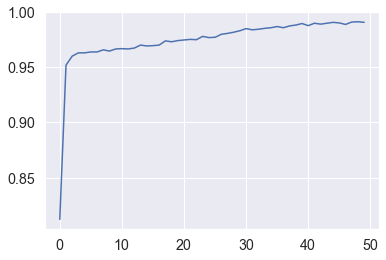

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


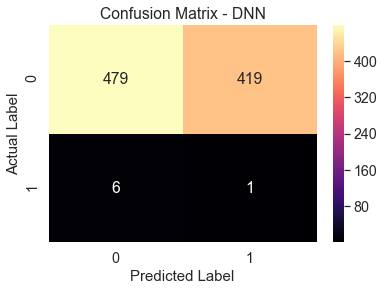

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      0.53      0.69       898
           1       0.00      0.14      0.00         7

    accuracy                           0.53       905
   macro avg       0.50      0.34      0.35       905
weighted avg       0.98      0.53      0.69       905



0

In [87]:
# Alternate PS
datasetJSONPath = os.getcwd() + "\\datasets\\empire_psremoting_stager_2020-09-20170827.json"
df4 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "Message", "Description", "ImageLoaded", "Image", "PipeName"]
df4 = df4[features]
Y4 = labelList(df4.shape[0], [2, 4, 7, 8, 12, 768, 799])

gen_data4 = json.read_json(os.getcwd() + "\\generated_datasets\\empire_psremoting_stager_new2.json")

DNN_classifier(df4, Y4, [2, 4, 7, 8, 12, 768, 799], gen_data4, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
266/266 - 1s - loss: nan - accuracy: 0.5022 - 609ms/epoch - 2ms/step
Epoch 2/50
266/266 - 0s - loss: nan - accuracy: 0.5042 - 193ms/epoch - 727us/step
Epoch 3/50
266/266 - 0s - loss: nan - accuracy: 0.5042 - 214ms/epoch - 805us/step
Epoch 4/50
266/266 - 0s - loss: nan - accuracy: 0.5042 - 221ms/epoch - 832us/step
Epoch 5/50
266/266 - 0s - loss: nan - accuracy: 0.50

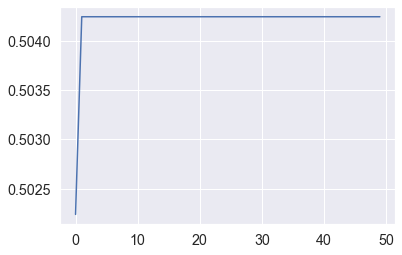

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


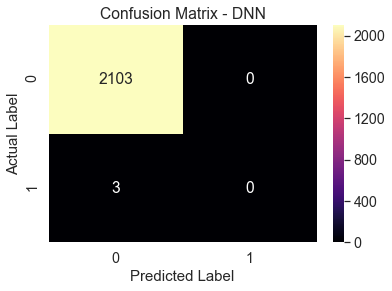

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2103
           1       0.00      0.00      0.00         3

    accuracy                           1.00      2106
   macro avg       0.50      0.50      0.50      2106
weighted avg       1.00      1.00      1.00      2106



C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0

In [88]:
# Remote WMI
datasetJSONPath = os.getcwd() + "\\datasets\\empire_wmi_dcerpc_wmi_IWbemServices_ExecMethod_2020-09-21001437.json"
df5 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "ParentProcessName", "TargetLogonId", "LogonType", "SubjectUserName", "ParentImage", "LogonId"]
df5 = df5[features]
Y5 = labelList(df5.shape[0], [551, 368, 514])

gen_data5 = json.read_json(os.getcwd() + "\\generated_datasets\\empire_wmi_dcerpc_wmi_IWbemServices_ExecMethod_new.json")

DNN_classifier(df5, Y5, [551, 368, 514], gen_data5, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
247/247 - 1s - loss: 0.6507 - accuracy: 0.7314 - 501ms/epoch - 2ms/step
Epoch 2/50
247/247 - 0s - loss: 0.5082 - accuracy: 0.7725 - 160ms/epoch - 647us/step
Epoch 3/50
247/247 - 0s - loss: 0.2804 - accuracy: 0.9824 - 162ms/epoch - 657us/step
Epoch 4/50
247/247 - 0s - loss: 0.2014 - accuracy: 0.9947 - 161ms/epoch - 652us/step
Epoch 5/50
247/247 - 0s - loss: 0.1649 -

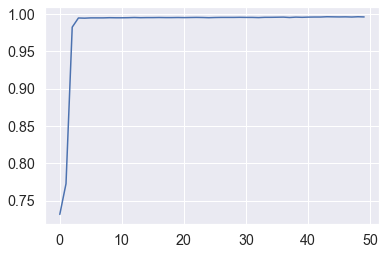

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


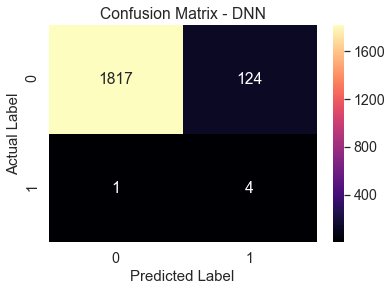

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1941
           1       0.03      0.80      0.06         5

    accuracy                           0.94      1946
   macro avg       0.52      0.87      0.51      1946
weighted avg       1.00      0.94      0.96      1946



0

In [90]:
# WMI Module
datasetJSONPath = os.getcwd() + "\\datasets\\empire_psinject_PEinjection_2020-08-07143205.json"
df6 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "ImageLoaded", "Image"]
df6 = df6[features]
Y6 = labelList(df6.shape[0], [2168, 2172, 2194, 2232, 2235])

gen_data6 = json.read_json(os.getcwd() + "\\generated_datasets\\empire_psinject_PEinjection_new.json")

DNN_classifier(df6, Y6, [2168, 2172, 2194, 2232, 2235], gen_data6, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
182/182 - 0s - loss: nan - accuracy: 0.5012 - 466ms/epoch - 3ms/step
Epoch 2/50
182/182 - 0s - loss: nan - accuracy: 0.5012 - 128ms/epoch - 705us/step
Epoch 3/50
182/182 - 0s - loss: nan - accuracy: 0.5012 - 121ms/epoch - 666us/step
Epoch 4/50
182/182 - 0s - loss: nan - accuracy: 0.5012 - 115ms/epoch - 629us/step
Epoch 5/50
182/182 - 0s - loss: nan - accuracy: 0.50

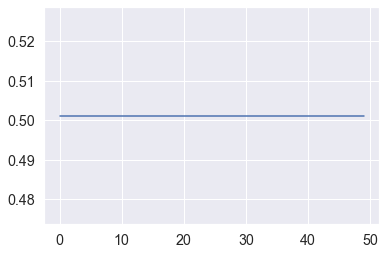

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


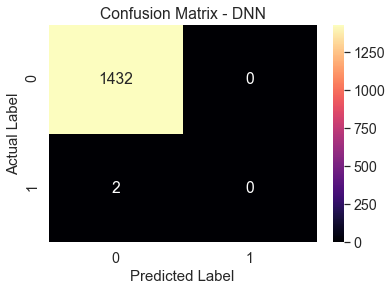

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1432
           1       0.00      0.00      0.00         2

    accuracy                           1.00      1434
   macro avg       0.50      0.50      0.50      1434
weighted avg       1.00      1.00      1.00      1434



C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0

In [91]:
# Remote Installation
datasetJSONPath = os.getcwd() + "\\datasets\\empire_psexec_dcerpc_tcp_svcctl_2020-09-20121608.json"
df7 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "SubjectUserName", "SubjectLogonId", "TargetLogonId", "LogonType"]
df7 = df7[features]
Y7 = labelList(df7.shape[0], [1212, 1028])

gen_data7 = json.read_json(os.getcwd() + "\\generated_datasets\\empire_psexec_dcerpc_tcp_svcctl_new.json")

DNN_classifier(df7, Y7, [1212, 1028], gen_data7, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
165/165 - 0s - loss: 0.2527 - accuracy: 0.9443 - 461ms/epoch - 3ms/step
Epoch 2/50
165/165 - 0s - loss: 0.0930 - accuracy: 0.9844 - 117ms/epoch - 710us/step
Epoch 3/50
165/165 - 0s - loss: 0.0806 - accuracy: 0.9859 - 136ms/epoch - 823us/step
Epoch 4/50
165/165 - 0s - loss: 0.0746 - accuracy: 0.9861 - 125ms/epoch - 756us/step
Epoch 5/50
165/165 - 0s - loss: 0.0699 -

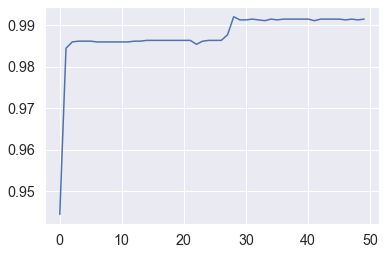

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


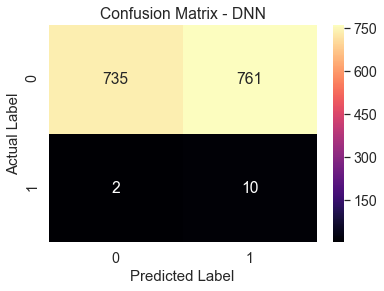

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.49      0.66      1496
           1       0.01      0.83      0.03        12

    accuracy                           0.49      1508
   macro avg       0.51      0.66      0.34      1508
weighted avg       0.99      0.49      0.65      1508



0

In [92]:
# Remote SCM Handle
datasetJSONPath = os.getcwd() + "\\datasets\\empire_find_localadmin_smb_svcctl_OpenSCManager_2020-09-22021559.json"
df8 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID","ObjectType", "ObjectName", "AccessMask", "SubjectLogonId", "PrivilegeList", "Application", "LayerRTID", "Image", "LogonType", "SubjectUserName", "TargetLogonId"]
df8 = df8[features]
Y8 = labelList(df8.shape[0], [1071, 1374, 854, 1066, 1100, 1372, 1373, 1374, 1375, 1368, 1070, 1068])

gen_data8 = json.read_json(os.getcwd() + "\\generated_datasets\\empire_find_localadmin_smb_svcctl_OpenSCManager_new.json")

DNN_classifier(df8, Y8, [1071, 1374, 854, 1066, 1100, 1372, 1373, 1374, 1375, 1368, 1070, 1068], gen_data8, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
245/245 - 0s - loss: 0.5487 - accuracy: 0.6943 - 498ms/epoch - 2ms/step
Epoch 2/50
245/245 - 0s - loss: 0.3053 - accuracy: 0.9913 - 161ms/epoch - 657us/step
Epoch 3/50
245/245 - 0s - loss: 0.2291 - accuracy: 0.9951 - 171ms/epoch - 698us/step
Epoch 4/50
245/245 - 0s - loss: 0.1894 - accuracy: 0.9958 - 174ms/epoch - 709us/step
Epoch 5/50
245/245 - 0s - loss: 0.1590 -

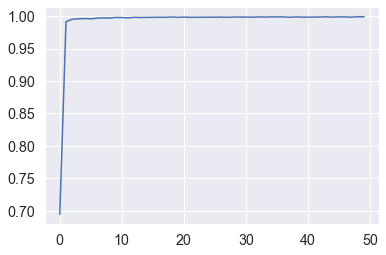

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


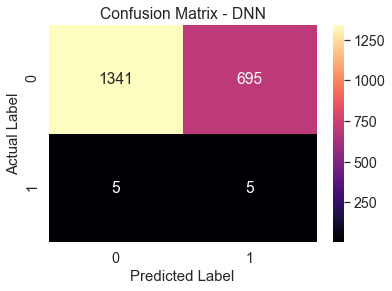

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.66      0.79      2036
           1       0.01      0.50      0.01        10

    accuracy                           0.66      2046
   macro avg       0.50      0.58      0.40      2046
weighted avg       0.99      0.66      0.79      2046



0

In [97]:
# Microphone
datasetJSONPath = os.getcwd() + "\\datasets\\msf_record_mic_2020-06-09225055.json"
df9 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "ObjectType", "ObjectName", "ProcessName", "SubjectLogonId", "ObjectValueName", "TargetObject"]
df9 = df9[features]
Y9 = labelList(df9.shape[0], [5117, 5118, 5202, 5203, 5204, 5240, 5241, 5242, 5340, 5344])

gen_data9 = json.read_json(os.getcwd() + "\\generated_datasets\\msf_record_mic_new.json")

DNN_classifier(df9, Y9, [5117, 5118, 5202, 5203, 5204, 5240, 5241, 5242, 5340, 5344], gen_data9, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/138 - 0s - loss: 0.5333 - accuracy: 0.7193 - 437ms/epoch - 3ms/step
Epoch 2/50
138/138 - 0s - loss: 0.3675 - accuracy: 0.9094 - 131ms/epoch - 949us/step
Epoch 3/50
138/138 - 0s - loss: 0.2956 - accuracy: 0.9608 - 151ms/epoch - 1ms/step
Epoch 4/50
138/138 - 0s - loss: 0.2580 - accuracy: 0.9709 - 143ms/epoch - 1ms/step
Epoch 5/50
138/138 - 0s - loss: 0.2311 - acc

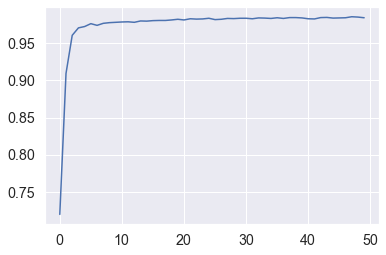

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


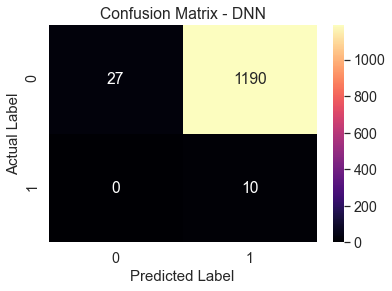

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.02      0.04      1217
           1       0.01      1.00      0.02        10

    accuracy                           0.03      1227
   macro avg       0.50      0.51      0.03      1227
weighted avg       0.99      0.03      0.04      1227



0

In [93]:
# Active Script
datasetJSONPath = os.getcwd() + "\\datasets\\covenant_wmi_remote_event_subscription_ActiveScriptEventConsumers_2020-09-01214330.json"
df10 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "Message", "Image", "NewProcessName", "ImageLoaded", "LogonType", "ProcessName", "ProcessGuid", "ProcessId"]
df10 = df10[features]
Y10 = labelList(df10.shape[0], [157, 3307, 156, 1532, 1744, 1537, 1591, 1600, 2151, 1799])

gen_data10 = json.read_json(os.getcwd() + "\\generated_datasets\\covenant_wmi_remote_event_subscription_ActiveScriptEventConsumers_new.json")


DNN_classifier(df10, Y10, [157, 3307, 156, 1532, 1744, 1537, 1591, 1600, 2151, 1799], gen_data10, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
313/313 - 1s - loss: 0.4007 - accuracy: 0.7992 - 562ms/epoch - 2ms/step
Epoch 2/50
313/313 - 0s - loss: 0.2169 - accuracy: 0.9984 - 208ms/epoch - 664us/step
Epoch 3/50
313/313 - 0s - loss: 0.1712 - accuracy: 0.9987 - 288ms/epoch - 920us/step
Epoch 4/50
313/313 - 0s - loss: 0.1386 - accuracy: 0.9990 - 302ms/epoch - 964us/step
Epoch 5/50
313/313 - 0s - loss: 0.1136 -

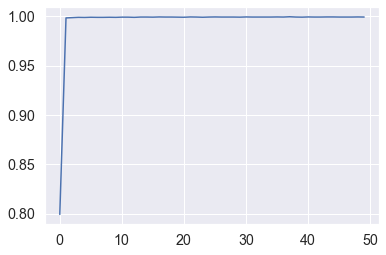

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


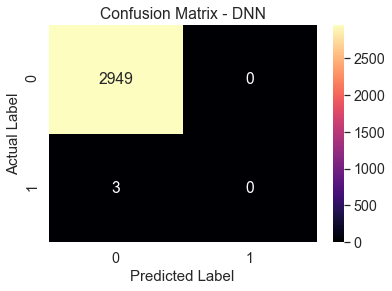

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2949
           1       0.00      0.00      0.00         3

    accuracy                           1.00      2952
   macro avg       0.50      0.50      0.50      2952
weighted avg       1.00      1.00      1.00      2952



C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0

In [94]:
# Wbemcomn Hijack
datasetJSONPath = os.getcwd() + "\\datasets\\covenant_wmi_wbemcomn_dll_hijack_2020-10-09173318.json"
df11 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "RelativeTargetName", "SubjectUserName", "AccessMask", "Image", "TargetFilename", "ImageLoaded"]
df11 = df11[features]
Y11 = labelList(df11.shape[0], [450, 445, 651])

gen_data11 = json.read_json(os.getcwd() + "\\generated_datasets\\covenant_wmi_wbemcomn_dll_hijack_new.json")

DNN_classifier(df11, Y11, [450, 445, 651], gen_data11, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
22/22 - 0s - loss: 0.6647 - accuracy: 0.6766 - 367ms/epoch - 17ms/step
Epoch 2/50
22/22 - 0s - loss: 0.5588 - accuracy: 0.8775 - 21ms/epoch - 954us/step
Epoch 3/50
22/22 - 0s - loss: 0.4733 - accuracy: 0.8903 - 23ms/epoch - 1ms/step
Epoch 4/50
22/22 - 0s - loss: 0.4084 - accuracy: 0.9088 - 22ms/epoch - 977us/step
Epoch 5/50
22/22 - 0s - loss: 0.3247 - accuracy: 0.9

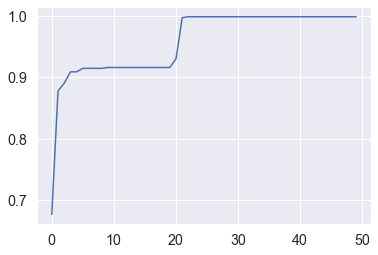

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


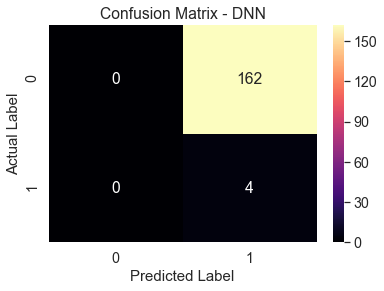

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.02      1.00      0.05         4

    accuracy                           0.02       166
   macro avg       0.01      0.50      0.02       166
weighted avg       0.00      0.02      0.00       166



C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0

In [95]:
# SMB Create
datasetJSONPath = os.getcwd() + "\\datasets\\covenant_copy_smb_CreateRequest_2020-09-22145302.json"
df12 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "ShareName", "SubjectUserName", "SubjectLogonId", "AccessMask", "Image", "RelativeTargetName", "TargetFilename"]
df12 = df12[features]
Y12 = labelList(df12.shape[0], [58, 57, 61, 211])

gen_data12 = json.read_json(os.getcwd() + "\\generated_datasets\\covenant_copy_smb_CreateRequest_new.json")

DNN_classifier(df12, Y12, [58, 57, 61, 211], gen_data12, hidden_layers=5, manually=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
34/34 - 0s - loss: 0.5746 - accuracy: 0.8254 - 398ms/epoch - 12ms/step
Epoch 2/50
34/34 - 0s - loss: 0.4591 - accuracy: 0.8254 - 29ms/epoch - 867us/step
Epoch 3/50
34/34 - 0s - loss: 0.3529 - accuracy: 0.8254 - 30ms/epoch - 875us/step
Epoch 4/50
34/34 - 0s - loss: 0.2805 - accuracy: 0.8254 - 27ms/epoch - 802us/step
Epoch 5/50
34/34 - 0s - loss: 0.2430 - accuracy: 0

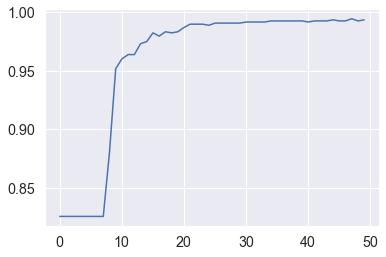

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


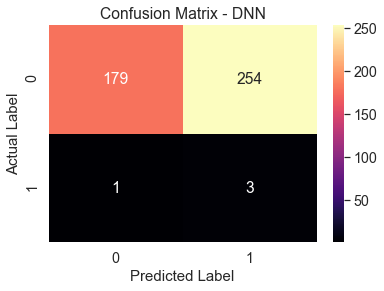

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      0.41      0.58       433
           1       0.01      0.75      0.02         4

    accuracy                           0.42       437
   macro avg       0.50      0.58      0.30       437
weighted avg       0.99      0.42      0.58       437



0

In [96]:
# Wuauclt
datasetJSONPath = os.getcwd() + "\\datasets\\covenant_lolbin_wuauclt_createremotethread_2020-10-12183248.json"
df13 = json.read_json(path_or_buf=datasetJSONPath, lines=True)

features = ["Channel", "EventID", "Image", "CommandLine", "Signed", "SourceImage", "ImageLoaded", "TargetFilename", "SourceProcessGuid", "ProcessGuid"]
df13 = df13[features]
Y13 = labelList(df13.shape[0], [593, 612, 613, 87])

gen_data13 = json.read_json(os.getcwd() + "\\generated_datasets\\covenant_lolbin_wuauclt_createremotethread_new.json")

DNN_classifier(df13, Y13, [593, 612, 613, 87], gen_data13, hidden_layers=5, manually=True)


___________________________________________________________________________

### Normalization

Z-score scaling: Standardize features by removing the mean and scaling to unit variance.
$$x' = \frac{x-\mu} {\sigma} \$$


In [29]:
# z-score scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_new)
X_test = scaler.fit_transform(X_test)

In [30]:
y_train = np.array(y_train)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
353/353 - 1s - loss: 0.3718 - accuracy: 0.9434 - auc: 0.9953 - 780ms/epoch - 2ms/step
Epoch 2/50
353/353 - 0s - loss: 0.2457 - accuracy: 0.9930 - auc: 0.9993 - 280ms/epoch - 794us/step
Epoch 3/50
353/353 - 0s - loss: 0.1890 - accuracy: 0.9978 - auc: 0.9995 - 290ms/epoch - 822us/step
Epoch 4/50
353/353 - 0s - loss: 0.0214 - accuracy: 0.9981 - auc: 0.9997 - 270ms/epo

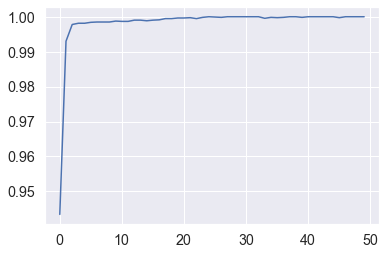

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_shape = (8,)

# Neuron counts for the first hidden layer were three times the number of input neurons needed for the feature vector,
# The neuron counts for subsequent hidden layers were half od the preceding layer

# Define the number of neurons in each hidden layer
hidden_counts = [24, 12, 6, 3]

# Define the number of output neurons
num_classes = 1

# Define the activation function for the hidden layers
activation_fn = 'relu'

# Define the weight initializer
initializer = GlorotUniform(seed=42)

# Define the optimizer
optimizer = Adam()

# Define the model architecture
model = tf.keras.Sequential()

# Add the input layer
model.add(layers.InputLayer(input_shape=input_shape))

# Add the hidden layers
for i, count in enumerate(hidden_counts):
    model.add(layers.Dense(count, activation=activation_fn, kernel_initializer=initializer, name=f'hidden_{i+1}'))

# Add the output layer
# model.add(layers.Dense(num_classes, activation='softmax', kernel_initializer=initializer, name='output'))
model.add(layers.Dense(num_classes, activation='sigmoid', kernel_initializer=initializer, name='output'))


# Compile the model
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

hist = model.fit(X_train_new, y_train, verbose=2, epochs=50)
plt.plot(hist.history['accuracy'])
plt.show()

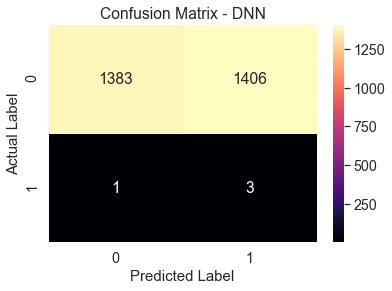

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.50      0.66      2789
           1       0.00      0.75      0.00         4

    accuracy                           0.50      2793
   macro avg       0.50      0.62      0.33      2793
weighted avg       1.00      0.50      0.66      2793



In [34]:
# prediction
from sklearn import metrics

y_predict = model.predict(X_test)
y_predict_class = np.where(y_predict >= 0.5, 1, 0) # use 0.5 as threshold
draw_confusionMatrix(y_test, y_predict_class)

------------------------------------------------------